<a href="https://colab.research.google.com/github/banno-0720/Deep-Learning-Projects/blob/main/Bach_Chorales_Music_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Music Transformer

The idea is to generate music from the dataset "JSB chorales".

The JSB chorales are a set of short, four-voice pieces of music well-noted for their stylistic homogeneity. The chorales were originally composed by Johann Sebastian Bach in the 18th century. He wrote them by first taking pre-existing melodies from contemporary Lutheran hymns and then harmonising them to create the parts for the remaining three voices. The version of the dataset used canonically in representation learning contexts consists of 382 such chorales, with a train/validation/test split of 229, 76 and 77 samples respectively.

In [37]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt

# Hyperparameters

In [26]:
EMBED_DIM = 128
N_HEADS = 8
FF_DIM = 512
NUM_LAYERS = 6
SEQ_LEN = 1024
BATCH_SIZE = 32
LR = 1e-4
EPOCHS = 100
VOCAB_SIZE = 4371
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Downloading dataset

In [3]:
!pip install opendatasets

In [4]:
import opendatasets as od

In [5]:
od.download("https://www.kaggle.com/datasets/pranjalsriv/bach-chorales-2")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: himanshugoyal2004
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/pranjalsriv/bach-chorales-2


100%|██████████| 190k/190k [00:00<00:00, 64.9MB/s]

# Data Loading And Preprocessing

In [6]:
pd.read_csv("/content/bach-chorales-2/test/chorale_305.csv")

,note0,note1,note2,note3
0,65,60,57,53
1,65,60,57,53
2,65,60,57,53
3,65,60,57,53
4,72,60,55,52
...,...,...,...,...
223,65,60,57,41
224,65,60,57,41
225,65,60,57,41
226,65,60,57,41


In [7]:
def load_chorale_csv(file_path):
    """
    Load a chorale CSV file and return a list of chord tuples.
    Each chord is a tuple (note0, note1, note2, note3) from one time step.
    """
    # If your CSVs are comma-separated, you can remove the sep argument
    df = pd.read_csv(file_path)

    chords = []
    # Iterate over rows; each row is a time step
    for _, row in df.iterrows():
        chord = (int(row['note0']), int(row['note1']), int(row['note2']), int(row['note3']))
        chords.append(chord)
    return chords

In [8]:
def load_jsb_chorales_from_folder(folder_path):
    """
    Load all chorale CSV files from a folder and return a list of sequences.
    Each sequence is a list of chord tuples.
    """
    sequences = []
    for file_name in sorted(os.listdir(folder_path)):
        file_path = os.path.join(folder_path, file_name)
        if file_path.endswith(".csv"):
            seq = load_chorale_csv(file_path)
            sequences.append(seq)
    return sequences


In [9]:
train_sequences = load_jsb_chorales_from_folder("/content/bach-chorales-2/train")
valid_sequences = load_jsb_chorales_from_folder("/content/bach-chorales-2/valid")
test_sequences  = load_jsb_chorales_from_folder("/content/bach-chorales-2/test")

In [10]:
def build_vocab(sequences):
    """
    Build a vocabulary mapping from chord tuples to unique integer indices.
    """
    vocab = {}
    for seq in sequences:
        for chord in seq:
            if chord not in vocab:
                vocab[chord] = len(vocab)

    # Add a special unknown token
    vocab['<UNK>'] = len(vocab)

    return vocab

In [11]:
# Build vocabulary from training sequences
vocab = build_vocab(train_sequences)
vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 4371


# DataLoader

In [12]:
class MusicDataset(Dataset):
    """
    Custom Dataset: Each chorale sequence is converted to a sequence of indices.
    For next-token prediction, the input is all tokens except the last,
    and the target is all tokens except the first.
    """
    def __init__(self, sequences, vocab):
        # Convert chord tuples in each sequence to indices using the provided vocab.
        # If a chord is not found, it will be replaced with the '<UNK>' token.
        self.sequences = [torch.tensor([vocab.get(chord, vocab['<UNK>']) for chord in seq]) for seq in sequences]

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        return seq[:-1], seq[1:]

In [13]:
def collate_fn(batch):
    """
    Pad variable-length sequences in a batch.
    """
    inputs, targets = zip(*batch)
    inputs = pad_sequence(inputs, batch_first=True, padding_value=0)
    targets = pad_sequence(targets, batch_first=True, padding_value=0)
    return inputs, targets

In [14]:
# Create datasets (convert chord tuples to indices)
train_dataset = MusicDataset(train_sequences, vocab)
valid_dataset = MusicDataset(valid_sequences, vocab)
test_dataset  = MusicDataset(test_sequences, vocab)

In [30]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

# Transformer Model

In [27]:
class MusicTransformer(nn.Module):
  def __init__(self, vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIM, num_heads=N_HEADS, ff_dim=FF_DIM, num_layers=NUM_LAYERS):
    super(MusicTransformer,self).__init__()
    self.embedding = nn.Embedding(vocab_size, embed_dim)
    # Learnable positional encoding; ensure its length covers your expected sequence lengths
    self.pos_encoding = nn.Parameter(torch.zeros(1, SEQ_LEN, embed_dim))
    encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim, batch_first=True)
    self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
    self.fc = nn.Linear(embed_dim, vocab_size)

  def forward(self, x):
    # Add positional encoding to the embed tokens
    x = self.embedding(x) + self.pos_encoding[:, :x.size(1), :]
    x = self.transformer(x)
    return self.fc(x)

In [28]:
# Initialize model, optimizer, and loss criterion
model = MusicTransformer(vocab_size).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

# Training Loop

In [40]:
train_losses = []
test_losses = []
test_accuracies = []

for epoch in range(EPOCHS):
  model.train()
  total_loss = 0
  for inputs, targets in train_loader:
    inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  train_losses.append(avg_loss)
  avg_loss = total_loss / len(train_loader)

  model.eval()  # Turn off dropout, etc.
  total_test_loss = 0
  correct = 0
  total_tokens = 0
  with torch.inference_mode():
      for inputs, targets in test_loader:
          inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
          test_pred = model(inputs)  # Forward pass
          loss = criterion(test_pred.view(-1, test_pred.size(-1)), targets.view(-1))
          total_test_loss += loss.item()

          # Calculate accuracy
          predictions = torch.argmax(test_pred, dim=-1)
          correct += (predictions == targets).sum().item()
          total_tokens += targets.numel()
  avg_test_loss = total_test_loss / len(test_loader)
  accuracy = correct / total_tokens * 100  # accuracy percentage
  test_losses.append(avg_test_loss)
  test_accuracies.append(accuracy)
  print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {avg_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

Epoch 1/20, Train Loss: 2.1933, Test Loss: 2.1993, Test Accuracy: 76.39%
Epoch 2/20, Train Loss: 2.2055, Test Loss: 2.1886, Test Accuracy: 76.51%
Epoch 3/20, Train Loss: 2.3065, Test Loss: 2.1838, Test Accuracy: 76.52%
Epoch 4/20, Train Loss: 2.2438, Test Loss: 2.1795, Test Accuracy: 76.60%
Epoch 5/20, Train Loss: 2.3030, Test Loss: 2.1746, Test Accuracy: 76.59%
Epoch 6/20, Train Loss: 2.0736, Test Loss: 2.1677, Test Accuracy: 76.65%
Epoch 7/20, Train Loss: 2.2025, Test Loss: 2.1596, Test Accuracy: 76.74%
Epoch 8/20, Train Loss: 2.2005, Test Loss: 2.1570, Test Accuracy: 76.79%
Epoch 9/20, Train Loss: 2.0833, Test Loss: 2.1540, Test Accuracy: 76.74%
Epoch 10/20, Train Loss: 2.2041, Test Loss: 2.1444, Test Accuracy: 76.78%
Epoch 11/20, Train Loss: 2.2358, Test Loss: 2.1387, Test Accuracy: 76.90%
Epoch 12/20, Train Loss: 2.2706, Test Loss: 2.1352, Test Accuracy: 76.90%
Epoch 13/20, Train Loss: 2.2868, Test Loss: 2.1300, Test Accuracy: 76.99%
Epoch 14/20, Train Loss: 2.1266, Test Loss: 2.1

# Visualize the model

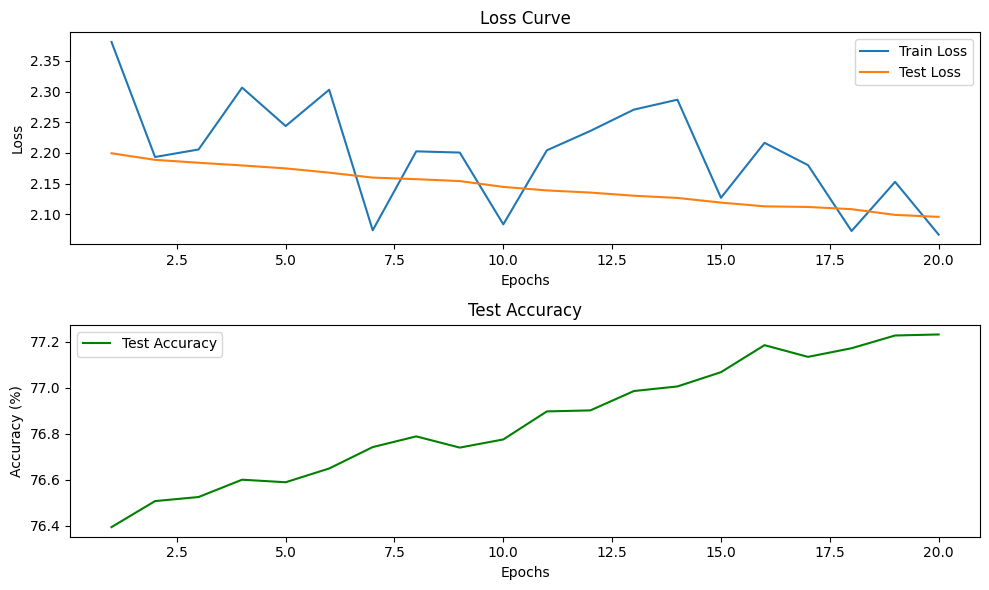

In [41]:
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(range(1, EPOCHS+1), train_losses, label="Train Loss")
plt.plot(range(1, EPOCHS+1), test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(range(1, EPOCHS+1), test_accuracies, label="Test Accuracy", color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy")
plt.legend()

plt.tight_layout()
plt.show()
# Ignore my graph it is trained again and again since i added the list later on and didnt restart the model

# Saving the model

In [42]:
torch.save(model.state_dict(), "music_transformer.pth")
print("Model saved as music_transformer.pth")

Model saved as music_transformer.pth


# ONNX Export

In [44]:
import torch.onnx

In [46]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 106.8 MB/s eta 0:00:00


In [47]:
# Create a dummy input for export with batch size 1 and sequence length SEQ_LEN
dummy_input = torch.randint(0, vocab_size, (1, SEQ_LEN), device=DEVICE)
torch.onnx.export(model, dummy_input, "music_transformer.onnx",
                  input_names=["input"], output_names=["output"],
                  dynamic_axes={"input": {0: "batch_size", 1: "seq_len"},
                                "output": {0: "batch_size", 1: "seq_len"}})
print("Model exported as music_transformer.onnx")

Model exported as music_transformer.onnx
